https://github.com/tristandeleu/pytorch-meta/blob/master/examples/maml/train.py
https://github.com/learnables/learn2learn/blob/master/examples/vision/maml_miniimagenet.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
# os.environ['WANDB_MODE']='offline'
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.meta_dataset import EchoDataset_Meta_heatmap
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb
import warnings
import learn2learn as l2l
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)

warnings.filterwarnings("ignore")


In [3]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join(CFG['save_path'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [4]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [5]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    height = 256#480   
    width = 256#640
    view = 'PLAX'
    dataset = 'EchoNetLVH_datasetV2'
    lr = 5e-3
    scheduler = 'None'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('mps')
    epochs = 50
    patience = 100
    batch_size = 16

    all_task_list = ['PLAX','PSAX','4CH', '2CH']
    meta_task_list = ['PLAX']#['PLAX','PSAX','4CH']

    ############## Meta Learing hyperparameter
    shot=20
    fast_lr = 0.1
    meta_batch_size=25, # num task, epoch ... 
    adaptation_steps=1,
    # num_iterations=60000,
    ############## Heatmap hyperparameter
    std = 15
    ##############
    model = 'UNet'
    backbone = 'resnet34'
    version = 'resnet34_imagenet'
    
CFG = cfg()
CFG['save_path'] = os.path.join('saved_model', '_'.join([CFG['model'], CFG['version']]))
os.makedirs(CFG['save_path'], exist_ok=True)

In [6]:
# run = wandb.init(project='2022KOHI_keypoint_detection|Meta Learning',
#                 group=CFG['version'],
#                 name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}|CFG['version']",
#                 entity='kyh',
#                 # config={k:v for k, v in CFG.items() if '__' not in k}
#                 config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
#                 )

# model, hist = run_training(model=model.to(CFG["device"]),
#              train_ds=train_ds, 
#              val_ds=val_ds, 
#              optimizer=optimizer, 
#              scheduler=fetch_scheduler(CFG, optimizer), 
#              criterion=criterion, 
#              CFG=CFG,
#              wandb=wandb)
             
# wandb.run.finish()

In [7]:
logger = log(CFG)
trace_func = logger.info

2022-11-08 22:29:08,998 - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-7ce18906-d3d2-41ad-9f3a-c09db806bbbb.json


2022-11-08 22:29:08,998 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-7ce18906-d3d2-41ad-9f3a-c09db806bbbb.json


2022-11-08 22:29:09,004 - Timezone: Asia/Seoul


2022-11-08 22:29:09,004 - root - INFO - Timezone: Asia/Seoul


2022-11-08 22:29:09,005 - Training Start


2022-11-08 22:29:09,005 - root - INFO - Training Start


In [8]:
dataset_dir = '../meta_dataset/' # 수정필요
CFG['dataset'] = dataset_dir.split('/')[-1]

## ⌗ Load Data

In [9]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        # img = (img - img.min()) / (img.max() - img.min())
        img = img / 255.
        return img
train_ts = A.Compose([
    A.Resize(CFG['height'], CFG['width']),
    MinMaxNormalize(p=1),

    ToTensorV2(),

],
    keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
        A.Resize(CFG['height'], CFG['width']),
        MinMaxNormalize(p=1),
        ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
        )


In [10]:
from utils.meta_dataset import EchoDataset_Meta_heatmap
train_ds = EchoDataset_Meta_heatmap(root=dataset_dir, 
                                    split='train', 
                                    shot=CFG['shot'],
                                    transforms=train_ts, 
                                    num_channels=3,
                                    task_list = ['PLAX', '4CH'])
val_ds = EchoDataset_Meta_heatmap(root=dataset_dir, 
                                  split='val', 
                                  shot=CFG['shot'],
                                  transforms=test_ts, 
                                  num_channels=3,
                                  task_list = ['PLAX','4CH'])#set(CFG['all_task_list']).difference(CFG['meta_task_list']))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=False)


In [11]:
train_dl.dataset.__len__()

40

## Load Model

In [12]:
# https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name=CFG['backbone'],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    # encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization # 수정필요
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
    activation='softmax'
)

In [13]:
import learn2learn as l2l
model = l2l.algorithms.MAML(model, lr=CFG['fast_lr'], first_order=False)

In [14]:
from utils.loss import HeatmapMSELoss, HeatmapOHKMMSELoss, JointsRMSELoss
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG.lr)
criterion = HeatmapMSELoss(use_target_weight=False)

In [15]:
from utils.train_metalearning import train_one_epoch, valid_one_epoch
def run_training(model, train_ds, val_ds, optimizer, scheduler, criterion, CFG, wandb):
    """
    모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
    """
    device = CFG['device']
    num_epochs = CFG['epochs']
    start = time.time()
    early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mde = np.inf
    best_metric_epoch = -1

    best_loss = np.inf
    best_loss_epoch = -1

    history = defaultdict(list)
    # 에폭만큼 학습 수행
    
    optimizer.zero_grad()
    train_dl = DataLoader(train_ds, batch_size=CFG['shot'], shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=CFG['shot'], shuffle=False)

    for epoch in range(1, num_epochs+1):
        del train_dl,val_dl
        gc.collect()
        train_ds.resample()
        val_ds.resample()
        model_ = model.clone()

        train_dl = DataLoader(train_ds, batch_size=CFG['shot']*2, shuffle=True)
        train_loss, train_mde, _ = train_one_epoch(model=model_, dataloader=train_dl, optimizer=optimizer, scheduler=scheduler, device=device, criterion=criterion, CFG=CFG)

        model_ = model.clone()
        val_dl = DataLoader(val_ds, batch_size=CFG['shot']*2, shuffle=False)
        val_loss, val_mde = valid_one_epoch(model=model_, dataloader=val_dl, device=device, criterion=criterion, CFG=CFG)
        early_stopping(val_loss, model)
        # for p in model.parameters():
        #     p.grad.data.mul_(1.0 / CFG['epochs'])
        optimizer.step()

        history['Train Loss'].append(train_loss)
        history['Train MDE'].append(train_mde)
        history['Valid Loss'].append(val_loss)
        history['Valid MDE'].append(val_mde)
        
        wandb.log({"Train Loss": train_loss, 
                "Train MDE": train_mde,
                "Valid Loss": val_loss,
                "Valid MDE": val_mde,
                "LR":scheduler.get_last_lr()[0] if CFG['scheduler'] != 'None' else optimizer.param_groups[0]['lr']
            }
            )

        trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
        if scheduler is not None:
            scheduler.step()

        # Val MDE가 개선된 경우
        if val_mde <= best_mde:
            trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
            best_mde = val_mde
            best_metric_epoch = epoch
            best_metric_model_wts = copy.deepcopy(model.state_dict())
            
            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Metric Epoch'] = best_metric_epoch

            model_name = f"best_metric_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(CFG['save_path'], model_name))

            trace_func(f"Model Saved")

        # Loss 개선되었을때
        if val_loss <= best_loss:
            trace_func(f"Valid Loss Importved ({best_loss:.4f} ---> {val_loss:.4f})")
            best_loss = val_loss
            best_loss_epoch = epoch
            best_loss_model_wts = copy.deepcopy(model.state_dict())

            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Loss Epoch'] = best_loss_epoch


            model_name = f"best_loss_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(CFG['save_path'], model_name))

        if early_stopping.early_stop:
            trace_func("Early stopping")
            break

    model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde

                }, 
                os.path.join(CFG['save_path'], model_name))
    
    end = time.time()
    time_elapsed = end-start
    trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
    trace_func("Best Val MDE: {:.4f}".format(best_loss))
    trace_func("Best Val Loss: {:.4f}".format(best_mde))

    model.load_state_dict(best_metric_model_wts)

    return model, history

In [16]:
CFG['device'] = 'cpu'

## Train

In [17]:
run = wandb.init(project='2022KOHI_keypoint_detection|Meta Learning',
                group=CFG['version'],
                name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}|CFG['version']",
                entity='kyh',
                # config={k:v for k, v in CFG.items() if '__' not in k}
                config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
                )

model, hist = run_training(model=model.to(CFG["device"]),
             train_ds=train_ds, 
             val_ds=val_ds, 
             optimizer=optimizer, 
             scheduler=fetch_scheduler(CFG, optimizer), 
             criterion=criterion, 
             CFG=CFG,
             wandb=wandb)
             
wandb.run.finish()

2022-11-08 22:29:11,962 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


2022-11-08 22:29:11,962 - wandb.jupyter - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kyh. Use `wandb login --relogin` to force relogin


Valid : 100%|██████████| 1/1 [00:05<00:00,  5.00s/it, valid_MDE=67.3261, valid_loss=5818.4697]


2022-11-08 22:29:46,328 - Validation loss decreased (inf --> 5818.469727))#.  Saving model ...


2022-11-08 22:29:46,328 - root - INFO - Validation loss decreased (inf --> 5818.469727))#.  Saving model ...


2022-11-08 22:29:46,389 - [Epoch 1/50: Train Loss: 5823.19775, Val Loss: 5818.46973, Train MDE: 68.98163, Val MDE: 67.32606


2022-11-08 22:29:46,389 - root - INFO - [Epoch 1/50: Train Loss: 5823.19775, Val Loss: 5818.46973, Train MDE: 68.98163, Val MDE: 67.32606


2022-11-08 22:29:46,392 - Valid Score Improved (inf ---> 67.3261)


2022-11-08 22:29:46,392 - root - INFO - Valid Score Improved (inf ---> 67.3261)


2022-11-08 22:29:46,773 - Model Saved


2022-11-08 22:29:46,773 - root - INFO - Model Saved


2022-11-08 22:29:46,780 - Valid Loss Importved (inf ---> 5818.4697)


2022-11-08 22:29:46,780 - root - INFO - Valid Loss Importved (inf ---> 5818.4697)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.89s/it, valid_MDE=75.1410, valid_loss=4330.7837]


2022-11-08 22:30:14,381 - Validation loss decreased (5818.469727 --> 4330.783691))#.  Saving model ...


2022-11-08 22:30:14,381 - root - INFO - Validation loss decreased (5818.469727 --> 4330.783691))#.  Saving model ...


2022-11-08 22:30:14,422 - [Epoch 2/50: Train Loss: 4348.33447, Val Loss: 4330.78369, Train MDE: 68.65577, Val MDE: 75.14099


2022-11-08 22:30:14,422 - root - INFO - [Epoch 2/50: Train Loss: 4348.33447, Val Loss: 4330.78369, Train MDE: 68.65577, Val MDE: 75.14099


2022-11-08 22:30:14,423 - Valid Loss Importved (5818.4697 ---> 4330.7837)


2022-11-08 22:30:14,423 - root - INFO - Valid Loss Importved (5818.4697 ---> 4330.7837)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.42s/it, valid_MDE=77.2692, valid_loss=3006.6685]


2022-11-08 22:30:40,751 - Validation loss decreased (4330.783691 --> 3006.668457))#.  Saving model ...


2022-11-08 22:30:40,751 - root - INFO - Validation loss decreased (4330.783691 --> 3006.668457))#.  Saving model ...


2022-11-08 22:30:40,794 - [Epoch 3/50: Train Loss: 2994.79688, Val Loss: 3006.66846, Train MDE: 72.44359, Val MDE: 77.26916


2022-11-08 22:30:40,794 - root - INFO - [Epoch 3/50: Train Loss: 2994.79688, Val Loss: 3006.66846, Train MDE: 72.44359, Val MDE: 77.26916


2022-11-08 22:30:40,796 - Valid Loss Importved (4330.7837 ---> 3006.6685)


2022-11-08 22:30:40,796 - root - INFO - Valid Loss Importved (4330.7837 ---> 3006.6685)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.45s/it, valid_MDE=87.8182, valid_loss=2089.2466]


2022-11-08 22:31:06,936 - Validation loss decreased (3006.668457 --> 2089.246582))#.  Saving model ...


2022-11-08 22:31:06,936 - root - INFO - Validation loss decreased (3006.668457 --> 2089.246582))#.  Saving model ...


2022-11-08 22:31:06,984 - [Epoch 4/50: Train Loss: 2075.95703, Val Loss: 2089.24658, Train MDE: 87.15278, Val MDE: 87.81822


2022-11-08 22:31:06,984 - root - INFO - [Epoch 4/50: Train Loss: 2075.95703, Val Loss: 2089.24658, Train MDE: 87.15278, Val MDE: 87.81822


2022-11-08 22:31:06,985 - Valid Loss Importved (3006.6685 ---> 2089.2466)


2022-11-08 22:31:06,985 - root - INFO - Valid Loss Importved (3006.6685 ---> 2089.2466)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.69s/it, valid_MDE=82.1693, valid_loss=1521.5226]


2022-11-08 22:31:34,021 - Validation loss decreased (2089.246582 --> 1521.522583))#.  Saving model ...


2022-11-08 22:31:34,021 - root - INFO - Validation loss decreased (2089.246582 --> 1521.522583))#.  Saving model ...


2022-11-08 22:31:34,064 - [Epoch 5/50: Train Loss: 1539.53735, Val Loss: 1521.52258, Train MDE: 82.39023, Val MDE: 82.16927


2022-11-08 22:31:34,064 - root - INFO - [Epoch 5/50: Train Loss: 1539.53735, Val Loss: 1521.52258, Train MDE: 82.39023, Val MDE: 82.16927


2022-11-08 22:31:34,065 - Valid Loss Importved (2089.2466 ---> 1521.5226)


2022-11-08 22:31:34,065 - root - INFO - Valid Loss Importved (2089.2466 ---> 1521.5226)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.59s/it, valid_MDE=105.1068, valid_loss=1154.5151]


2022-11-08 22:32:00,370 - Validation loss decreased (1521.522583 --> 1154.515137))#.  Saving model ...


2022-11-08 22:32:00,370 - root - INFO - Validation loss decreased (1521.522583 --> 1154.515137))#.  Saving model ...


2022-11-08 22:32:00,414 - [Epoch 6/50: Train Loss: 1171.21912, Val Loss: 1154.51514, Train MDE: 103.59478, Val MDE: 105.10682


2022-11-08 22:32:00,414 - root - INFO - [Epoch 6/50: Train Loss: 1171.21912, Val Loss: 1154.51514, Train MDE: 103.59478, Val MDE: 105.10682


2022-11-08 22:32:00,415 - Valid Loss Importved (1521.5226 ---> 1154.5151)


2022-11-08 22:32:00,415 - root - INFO - Valid Loss Importved (1521.5226 ---> 1154.5151)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.47s/it, valid_MDE=100.3101, valid_loss=870.8688]


2022-11-08 22:32:26,721 - Validation loss decreased (1154.515137 --> 870.868835))#.  Saving model ...


2022-11-08 22:32:26,721 - root - INFO - Validation loss decreased (1154.515137 --> 870.868835))#.  Saving model ...


2022-11-08 22:32:26,767 - [Epoch 7/50: Train Loss: 854.57062, Val Loss: 870.86884, Train MDE: 97.99593, Val MDE: 100.31008


2022-11-08 22:32:26,767 - root - INFO - [Epoch 7/50: Train Loss: 854.57062, Val Loss: 870.86884, Train MDE: 97.99593, Val MDE: 100.31008


2022-11-08 22:32:26,768 - Valid Loss Importved (1154.5151 ---> 870.8688)


2022-11-08 22:32:26,768 - root - INFO - Valid Loss Importved (1154.5151 ---> 870.8688)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.46s/it, valid_MDE=100.2081, valid_loss=619.0858]


2022-11-08 22:32:53,136 - Validation loss decreased (870.868835 --> 619.085815))#.  Saving model ...


2022-11-08 22:32:53,136 - root - INFO - Validation loss decreased (870.868835 --> 619.085815))#.  Saving model ...


2022-11-08 22:32:53,178 - [Epoch 8/50: Train Loss: 625.89630, Val Loss: 619.08582, Train MDE: 93.50169, Val MDE: 100.20805


2022-11-08 22:32:53,178 - root - INFO - [Epoch 8/50: Train Loss: 625.89630, Val Loss: 619.08582, Train MDE: 93.50169, Val MDE: 100.20805


2022-11-08 22:32:53,179 - Valid Loss Importved (870.8688 ---> 619.0858)


2022-11-08 22:32:53,179 - root - INFO - Valid Loss Importved (870.8688 ---> 619.0858)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.76s/it, valid_MDE=102.0040, valid_loss=564.2571]


2022-11-08 22:33:19,751 - Validation loss decreased (619.085815 --> 564.257080))#.  Saving model ...


2022-11-08 22:33:19,751 - root - INFO - Validation loss decreased (619.085815 --> 564.257080))#.  Saving model ...


2022-11-08 22:33:19,797 - [Epoch 9/50: Train Loss: 564.99219, Val Loss: 564.25708, Train MDE: 94.98861, Val MDE: 102.00401


2022-11-08 22:33:19,797 - root - INFO - [Epoch 9/50: Train Loss: 564.99219, Val Loss: 564.25708, Train MDE: 94.98861, Val MDE: 102.00401


2022-11-08 22:33:19,799 - Valid Loss Importved (619.0858 ---> 564.2571)


2022-11-08 22:33:19,799 - root - INFO - Valid Loss Importved (619.0858 ---> 564.2571)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.45s/it, valid_MDE=112.5912, valid_loss=571.3182]


2022-11-08 22:33:46,008 - EarlyStopping counter: 1 out of 100


2022-11-08 22:33:46,008 - root - INFO - EarlyStopping counter: 1 out of 100


2022-11-08 22:33:46,049 - [Epoch 10/50: Train Loss: 568.37244, Val Loss: 571.31818, Train MDE: 109.77932, Val MDE: 112.59121


2022-11-08 22:33:46,049 - root - INFO - [Epoch 10/50: Train Loss: 568.37244, Val Loss: 571.31818, Train MDE: 109.77932, Val MDE: 112.59121
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.55s/it, valid_MDE=111.7523, valid_loss=584.6058]


2022-11-08 22:34:12,337 - EarlyStopping counter: 2 out of 100


2022-11-08 22:34:12,337 - root - INFO - EarlyStopping counter: 2 out of 100


2022-11-08 22:34:12,380 - [Epoch 11/50: Train Loss: 586.01672, Val Loss: 584.60583, Train MDE: 114.28007, Val MDE: 111.75230


2022-11-08 22:34:12,380 - root - INFO - [Epoch 11/50: Train Loss: 586.01672, Val Loss: 584.60583, Train MDE: 114.28007, Val MDE: 111.75230
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.42s/it, valid_MDE=99.6811, valid_loss=598.2513]


2022-11-08 22:34:38,334 - EarlyStopping counter: 3 out of 100


2022-11-08 22:34:38,334 - root - INFO - EarlyStopping counter: 3 out of 100


2022-11-08 22:34:38,379 - [Epoch 12/50: Train Loss: 597.71899, Val Loss: 598.25134, Train MDE: 103.05151, Val MDE: 99.68109


2022-11-08 22:34:38,379 - root - INFO - [Epoch 12/50: Train Loss: 597.71899, Val Loss: 598.25134, Train MDE: 103.05151, Val MDE: 99.68109
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, valid_MDE=95.5940, valid_loss=606.4842]


2022-11-08 22:35:03,897 - EarlyStopping counter: 4 out of 100


2022-11-08 22:35:03,897 - root - INFO - EarlyStopping counter: 4 out of 100


2022-11-08 22:35:03,945 - [Epoch 13/50: Train Loss: 602.99329, Val Loss: 606.48419, Train MDE: 97.92757, Val MDE: 95.59402


2022-11-08 22:35:03,945 - root - INFO - [Epoch 13/50: Train Loss: 602.99329, Val Loss: 606.48419, Train MDE: 97.92757, Val MDE: 95.59402
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.54s/it, valid_MDE=96.6261, valid_loss=602.6063]


2022-11-08 22:35:29,837 - EarlyStopping counter: 5 out of 100


2022-11-08 22:35:29,837 - root - INFO - EarlyStopping counter: 5 out of 100


2022-11-08 22:35:29,880 - [Epoch 14/50: Train Loss: 606.79846, Val Loss: 602.60632, Train MDE: 96.84727, Val MDE: 96.62613


2022-11-08 22:35:29,880 - root - INFO - [Epoch 14/50: Train Loss: 606.79846, Val Loss: 602.60632, Train MDE: 96.84727, Val MDE: 96.62613
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.36s/it, valid_MDE=93.9835, valid_loss=602.4322]


2022-11-08 22:35:55,447 - EarlyStopping counter: 6 out of 100


2022-11-08 22:35:55,447 - root - INFO - EarlyStopping counter: 6 out of 100


2022-11-08 22:35:55,491 - [Epoch 15/50: Train Loss: 603.96515, Val Loss: 602.43219, Train MDE: 93.09202, Val MDE: 93.98347


2022-11-08 22:35:55,491 - root - INFO - [Epoch 15/50: Train Loss: 603.96515, Val Loss: 602.43219, Train MDE: 93.09202, Val MDE: 93.98347
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.59s/it, valid_MDE=94.8569, valid_loss=599.7698]


2022-11-08 22:36:21,836 - EarlyStopping counter: 7 out of 100


2022-11-08 22:36:21,836 - root - INFO - EarlyStopping counter: 7 out of 100


2022-11-08 22:36:21,885 - [Epoch 16/50: Train Loss: 598.02203, Val Loss: 599.76984, Train MDE: 95.20984, Val MDE: 94.85688


2022-11-08 22:36:21,885 - root - INFO - [Epoch 16/50: Train Loss: 598.02203, Val Loss: 599.76984, Train MDE: 95.20984, Val MDE: 94.85688
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.46s/it, valid_MDE=87.0553, valid_loss=597.6902]


2022-11-08 22:36:47,783 - EarlyStopping counter: 8 out of 100


2022-11-08 22:36:47,783 - root - INFO - EarlyStopping counter: 8 out of 100


2022-11-08 22:36:47,825 - [Epoch 17/50: Train Loss: 600.97083, Val Loss: 597.69025, Train MDE: 96.92308, Val MDE: 87.05535


2022-11-08 22:36:47,825 - root - INFO - [Epoch 17/50: Train Loss: 600.97083, Val Loss: 597.69025, Train MDE: 96.92308, Val MDE: 87.05535
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.40s/it, valid_MDE=93.9394, valid_loss=596.9640]


2022-11-08 22:37:13,599 - EarlyStopping counter: 9 out of 100


2022-11-08 22:37:13,599 - root - INFO - EarlyStopping counter: 9 out of 100


2022-11-08 22:37:13,646 - [Epoch 18/50: Train Loss: 600.84052, Val Loss: 596.96399, Train MDE: 97.83348, Val MDE: 93.93943


2022-11-08 22:37:13,646 - root - INFO - [Epoch 18/50: Train Loss: 600.84052, Val Loss: 596.96399, Train MDE: 97.83348, Val MDE: 93.93943
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, valid_MDE=95.0789, valid_loss=598.5342]


2022-11-08 22:37:39,399 - EarlyStopping counter: 10 out of 100


2022-11-08 22:37:39,399 - root - INFO - EarlyStopping counter: 10 out of 100


2022-11-08 22:37:39,458 - [Epoch 19/50: Train Loss: 602.33447, Val Loss: 598.53418, Train MDE: 92.60039, Val MDE: 95.07886


2022-11-08 22:37:39,458 - root - INFO - [Epoch 19/50: Train Loss: 602.33447, Val Loss: 598.53418, Train MDE: 92.60039, Val MDE: 95.07886
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.39s/it, valid_MDE=97.8634, valid_loss=600.9124]


2022-11-08 22:38:05,074 - EarlyStopping counter: 11 out of 100


2022-11-08 22:38:05,074 - root - INFO - EarlyStopping counter: 11 out of 100


2022-11-08 22:38:05,117 - [Epoch 20/50: Train Loss: 601.59827, Val Loss: 600.91235, Train MDE: 93.36289, Val MDE: 97.86336


2022-11-08 22:38:05,117 - root - INFO - [Epoch 20/50: Train Loss: 601.59827, Val Loss: 600.91235, Train MDE: 93.36289, Val MDE: 97.86336
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.39s/it, valid_MDE=99.7765, valid_loss=602.2661]


2022-11-08 22:38:30,732 - EarlyStopping counter: 12 out of 100


2022-11-08 22:38:30,732 - root - INFO - EarlyStopping counter: 12 out of 100


2022-11-08 22:38:30,786 - [Epoch 21/50: Train Loss: 604.44116, Val Loss: 602.26605, Train MDE: 92.30333, Val MDE: 99.77645


2022-11-08 22:38:30,786 - root - INFO - [Epoch 21/50: Train Loss: 604.44116, Val Loss: 602.26605, Train MDE: 92.30333, Val MDE: 99.77645
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.35s/it, valid_MDE=96.0624, valid_loss=603.1479]


2022-11-08 22:38:56,437 - EarlyStopping counter: 13 out of 100


2022-11-08 22:38:56,437 - root - INFO - EarlyStopping counter: 13 out of 100


2022-11-08 22:38:56,479 - [Epoch 22/50: Train Loss: 607.26300, Val Loss: 603.14795, Train MDE: 98.00131, Val MDE: 96.06242


2022-11-08 22:38:56,479 - root - INFO - [Epoch 22/50: Train Loss: 607.26300, Val Loss: 603.14795, Train MDE: 98.00131, Val MDE: 96.06242
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.53s/it, valid_MDE=91.6198, valid_loss=602.7291]


2022-11-08 22:39:22,301 - EarlyStopping counter: 14 out of 100


2022-11-08 22:39:22,301 - root - INFO - EarlyStopping counter: 14 out of 100


2022-11-08 22:39:22,345 - [Epoch 23/50: Train Loss: 603.92200, Val Loss: 602.72913, Train MDE: 87.32705, Val MDE: 91.61981


2022-11-08 22:39:22,345 - root - INFO - [Epoch 23/50: Train Loss: 603.92200, Val Loss: 602.72913, Train MDE: 87.32705, Val MDE: 91.61981
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.28s/it, valid_MDE=89.3276, valid_loss=601.6876]


2022-11-08 22:39:47,960 - EarlyStopping counter: 15 out of 100


2022-11-08 22:39:47,960 - root - INFO - EarlyStopping counter: 15 out of 100


2022-11-08 22:39:48,025 - [Epoch 24/50: Train Loss: 598.61731, Val Loss: 601.68762, Train MDE: 92.74552, Val MDE: 89.32765


2022-11-08 22:39:48,025 - root - INFO - [Epoch 24/50: Train Loss: 598.61731, Val Loss: 601.68762, Train MDE: 92.74552, Val MDE: 89.32765
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.52s/it, valid_MDE=97.1008, valid_loss=602.2206]


2022-11-08 22:40:14,415 - EarlyStopping counter: 16 out of 100


2022-11-08 22:40:14,415 - root - INFO - EarlyStopping counter: 16 out of 100


2022-11-08 22:40:14,456 - [Epoch 25/50: Train Loss: 603.03516, Val Loss: 602.22064, Train MDE: 93.08054, Val MDE: 97.10078


2022-11-08 22:40:14,456 - root - INFO - [Epoch 25/50: Train Loss: 603.03516, Val Loss: 602.22064, Train MDE: 93.08054, Val MDE: 97.10078
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.28s/it, valid_MDE=97.4477, valid_loss=596.7134]


2022-11-08 22:40:39,959 - EarlyStopping counter: 17 out of 100


2022-11-08 22:40:39,959 - root - INFO - EarlyStopping counter: 17 out of 100


2022-11-08 22:40:40,001 - [Epoch 26/50: Train Loss: 596.53461, Val Loss: 596.71344, Train MDE: 91.66860, Val MDE: 97.44769


2022-11-08 22:40:40,001 - root - INFO - [Epoch 26/50: Train Loss: 596.53461, Val Loss: 596.71344, Train MDE: 91.66860, Val MDE: 97.44769
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.26s/it, valid_MDE=85.8705, valid_loss=595.2015]


2022-11-08 22:41:05,233 - EarlyStopping counter: 18 out of 100


2022-11-08 22:41:05,233 - root - INFO - EarlyStopping counter: 18 out of 100


2022-11-08 22:41:05,273 - [Epoch 27/50: Train Loss: 597.92688, Val Loss: 595.20148, Train MDE: 92.67897, Val MDE: 85.87050


2022-11-08 22:41:05,273 - root - INFO - [Epoch 27/50: Train Loss: 597.92688, Val Loss: 595.20148, Train MDE: 92.67897, Val MDE: 85.87050
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.62s/it, valid_MDE=93.5159, valid_loss=592.8466]


2022-11-08 22:41:31,584 - EarlyStopping counter: 19 out of 100


2022-11-08 22:41:31,584 - root - INFO - EarlyStopping counter: 19 out of 100


2022-11-08 22:41:31,624 - [Epoch 28/50: Train Loss: 590.60645, Val Loss: 592.84656, Train MDE: 83.94810, Val MDE: 93.51587


2022-11-08 22:41:31,624 - root - INFO - [Epoch 28/50: Train Loss: 590.60645, Val Loss: 592.84656, Train MDE: 83.94810, Val MDE: 93.51587
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.54s/it, valid_MDE=84.7909, valid_loss=591.3195]


2022-11-08 22:41:57,395 - EarlyStopping counter: 20 out of 100


2022-11-08 22:41:57,395 - root - INFO - EarlyStopping counter: 20 out of 100


2022-11-08 22:41:57,438 - [Epoch 29/50: Train Loss: 588.03601, Val Loss: 591.31946, Train MDE: 85.40358, Val MDE: 84.79089


2022-11-08 22:41:57,438 - root - INFO - [Epoch 29/50: Train Loss: 588.03601, Val Loss: 591.31946, Train MDE: 85.40358, Val MDE: 84.79089
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.30s/it, valid_MDE=86.4781, valid_loss=580.2914]


2022-11-08 22:42:22,578 - EarlyStopping counter: 21 out of 100


2022-11-08 22:42:22,578 - root - INFO - EarlyStopping counter: 21 out of 100


2022-11-08 22:42:22,621 - [Epoch 30/50: Train Loss: 581.44128, Val Loss: 580.29138, Train MDE: 91.13658, Val MDE: 86.47815


2022-11-08 22:42:22,621 - root - INFO - [Epoch 30/50: Train Loss: 581.44128, Val Loss: 580.29138, Train MDE: 91.13658, Val MDE: 86.47815
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.29s/it, valid_MDE=83.7209, valid_loss=576.5381]


2022-11-08 22:42:47,670 - EarlyStopping counter: 22 out of 100


2022-11-08 22:42:47,670 - root - INFO - EarlyStopping counter: 22 out of 100


2022-11-08 22:42:47,715 - [Epoch 31/50: Train Loss: 580.68964, Val Loss: 576.53809, Train MDE: 85.89053, Val MDE: 83.72094


2022-11-08 22:42:47,715 - root - INFO - [Epoch 31/50: Train Loss: 580.68964, Val Loss: 576.53809, Train MDE: 85.89053, Val MDE: 83.72094
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, valid_MDE=81.4161, valid_loss=574.9575]


2022-11-08 22:43:12,771 - EarlyStopping counter: 23 out of 100


2022-11-08 22:43:12,771 - root - INFO - EarlyStopping counter: 23 out of 100


2022-11-08 22:43:12,813 - [Epoch 32/50: Train Loss: 567.03253, Val Loss: 574.95752, Train MDE: 81.48302, Val MDE: 81.41613


2022-11-08 22:43:12,813 - root - INFO - [Epoch 32/50: Train Loss: 567.03253, Val Loss: 574.95752, Train MDE: 81.48302, Val MDE: 81.41613
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.32s/it, valid_MDE=85.7587, valid_loss=573.7887]


2022-11-08 22:43:37,915 - EarlyStopping counter: 24 out of 100


2022-11-08 22:43:37,915 - root - INFO - EarlyStopping counter: 24 out of 100


2022-11-08 22:43:37,960 - [Epoch 33/50: Train Loss: 566.94690, Val Loss: 573.78870, Train MDE: 83.82353, Val MDE: 85.75870


2022-11-08 22:43:37,960 - root - INFO - [Epoch 33/50: Train Loss: 566.94690, Val Loss: 573.78870, Train MDE: 83.82353, Val MDE: 85.75870
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.27s/it, valid_MDE=78.3959, valid_loss=570.4521]


2022-11-08 22:44:03,071 - EarlyStopping counter: 25 out of 100


2022-11-08 22:44:03,071 - root - INFO - EarlyStopping counter: 25 out of 100


2022-11-08 22:44:03,115 - [Epoch 34/50: Train Loss: 563.61963, Val Loss: 570.45209, Train MDE: 78.56783, Val MDE: 78.39593


2022-11-08 22:44:03,115 - root - INFO - [Epoch 34/50: Train Loss: 563.61963, Val Loss: 570.45209, Train MDE: 78.56783, Val MDE: 78.39593
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.27s/it, valid_MDE=66.4911, valid_loss=569.6343]


2022-11-08 22:44:28,126 - EarlyStopping counter: 26 out of 100


2022-11-08 22:44:28,126 - root - INFO - EarlyStopping counter: 26 out of 100


2022-11-08 22:44:28,168 - [Epoch 35/50: Train Loss: 564.80640, Val Loss: 569.63428, Train MDE: 65.51941, Val MDE: 66.49106


2022-11-08 22:44:28,168 - root - INFO - [Epoch 35/50: Train Loss: 564.80640, Val Loss: 569.63428, Train MDE: 65.51941, Val MDE: 66.49106


2022-11-08 22:44:28,169 - Valid Score Improved (67.3261 ---> 66.4911)


2022-11-08 22:44:28,169 - root - INFO - Valid Score Improved (67.3261 ---> 66.4911)


2022-11-08 22:44:28,328 - Model Saved


2022-11-08 22:44:28,328 - root - INFO - Model Saved
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.25s/it, valid_MDE=53.5185, valid_loss=574.7371]


2022-11-08 22:44:53,324 - EarlyStopping counter: 27 out of 100


2022-11-08 22:44:53,324 - root - INFO - EarlyStopping counter: 27 out of 100


2022-11-08 22:44:53,366 - [Epoch 36/50: Train Loss: 569.55286, Val Loss: 574.73712, Train MDE: 59.80239, Val MDE: 53.51855


2022-11-08 22:44:53,366 - root - INFO - [Epoch 36/50: Train Loss: 569.55286, Val Loss: 574.73712, Train MDE: 59.80239, Val MDE: 53.51855


2022-11-08 22:44:53,367 - Valid Score Improved (66.4911 ---> 53.5185)


2022-11-08 22:44:53,367 - root - INFO - Valid Score Improved (66.4911 ---> 53.5185)


2022-11-08 22:44:53,527 - Model Saved


2022-11-08 22:44:53,527 - root - INFO - Model Saved
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.29s/it, valid_MDE=56.9150, valid_loss=573.1255]


2022-11-08 22:45:18,525 - EarlyStopping counter: 28 out of 100


2022-11-08 22:45:18,525 - root - INFO - EarlyStopping counter: 28 out of 100


2022-11-08 22:45:18,568 - [Epoch 37/50: Train Loss: 562.54657, Val Loss: 573.12549, Train MDE: 59.95629, Val MDE: 56.91496


2022-11-08 22:45:18,568 - root - INFO - [Epoch 37/50: Train Loss: 562.54657, Val Loss: 573.12549, Train MDE: 59.95629, Val MDE: 56.91496
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.34s/it, valid_MDE=54.1075, valid_loss=568.5529]


2022-11-08 22:45:43,633 - EarlyStopping counter: 29 out of 100


2022-11-08 22:45:43,633 - root - INFO - EarlyStopping counter: 29 out of 100


2022-11-08 22:45:43,677 - [Epoch 38/50: Train Loss: 555.21497, Val Loss: 568.55292, Train MDE: 51.57932, Val MDE: 54.10755


2022-11-08 22:45:43,677 - root - INFO - [Epoch 38/50: Train Loss: 555.21497, Val Loss: 568.55292, Train MDE: 51.57932, Val MDE: 54.10755
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.31s/it, valid_MDE=52.8101, valid_loss=549.7205]


2022-11-08 22:46:08,892 - Validation loss decreased (564.257080 --> 549.720459))#.  Saving model ...


2022-11-08 22:46:08,892 - root - INFO - Validation loss decreased (564.257080 --> 549.720459))#.  Saving model ...


2022-11-08 22:46:08,934 - [Epoch 39/50: Train Loss: 540.45734, Val Loss: 549.72046, Train MDE: 52.99422, Val MDE: 52.81013


2022-11-08 22:46:08,934 - root - INFO - [Epoch 39/50: Train Loss: 540.45734, Val Loss: 549.72046, Train MDE: 52.99422, Val MDE: 52.81013


2022-11-08 22:46:08,936 - Valid Score Improved (53.5185 ---> 52.8101)


2022-11-08 22:46:08,936 - root - INFO - Valid Score Improved (53.5185 ---> 52.8101)


2022-11-08 22:46:09,097 - Model Saved


2022-11-08 22:46:09,097 - root - INFO - Model Saved


2022-11-08 22:46:09,098 - Valid Loss Importved (564.2571 ---> 549.7205)


2022-11-08 22:46:09,098 - root - INFO - Valid Loss Importved (564.2571 ---> 549.7205)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.56s/it, valid_MDE=53.8977, valid_loss=527.8185]


2022-11-08 22:46:35,372 - Validation loss decreased (549.720459 --> 527.818481))#.  Saving model ...


2022-11-08 22:46:35,372 - root - INFO - Validation loss decreased (549.720459 --> 527.818481))#.  Saving model ...


2022-11-08 22:46:35,422 - [Epoch 40/50: Train Loss: 518.44806, Val Loss: 527.81848, Train MDE: 57.63041, Val MDE: 53.89775


2022-11-08 22:46:35,422 - root - INFO - [Epoch 40/50: Train Loss: 518.44806, Val Loss: 527.81848, Train MDE: 57.63041, Val MDE: 53.89775


2022-11-08 22:46:35,424 - Valid Loss Importved (549.7205 ---> 527.8185)


2022-11-08 22:46:35,424 - root - INFO - Valid Loss Importved (549.7205 ---> 527.8185)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.31s/it, valid_MDE=65.2297, valid_loss=518.0236]


2022-11-08 22:47:01,469 - Validation loss decreased (527.818481 --> 518.023560))#.  Saving model ...


2022-11-08 22:47:01,469 - root - INFO - Validation loss decreased (527.818481 --> 518.023560))#.  Saving model ...


2022-11-08 22:47:01,512 - [Epoch 41/50: Train Loss: 520.10791, Val Loss: 518.02356, Train MDE: 64.87306, Val MDE: 65.22975


2022-11-08 22:47:01,512 - root - INFO - [Epoch 41/50: Train Loss: 520.10791, Val Loss: 518.02356, Train MDE: 64.87306, Val MDE: 65.22975


2022-11-08 22:47:01,513 - Valid Loss Importved (527.8185 ---> 518.0236)


2022-11-08 22:47:01,513 - root - INFO - Valid Loss Importved (527.8185 ---> 518.0236)
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.50s/it, valid_MDE=79.8040, valid_loss=527.7367]


2022-11-08 22:47:27,719 - EarlyStopping counter: 1 out of 100


2022-11-08 22:47:27,719 - root - INFO - EarlyStopping counter: 1 out of 100


2022-11-08 22:47:27,763 - [Epoch 42/50: Train Loss: 526.86853, Val Loss: 527.73669, Train MDE: 78.43979, Val MDE: 79.80401


2022-11-08 22:47:27,763 - root - INFO - [Epoch 42/50: Train Loss: 526.86853, Val Loss: 527.73669, Train MDE: 78.43979, Val MDE: 79.80401
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.50s/it, valid_MDE=83.0496, valid_loss=543.6400]


2022-11-08 22:47:53,669 - EarlyStopping counter: 2 out of 100


2022-11-08 22:47:53,669 - root - INFO - EarlyStopping counter: 2 out of 100


2022-11-08 22:47:53,711 - [Epoch 43/50: Train Loss: 542.76404, Val Loss: 543.64001, Train MDE: 78.85288, Val MDE: 83.04964


2022-11-08 22:47:53,711 - root - INFO - [Epoch 43/50: Train Loss: 542.76404, Val Loss: 543.64001, Train MDE: 78.85288, Val MDE: 83.04964
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.62s/it, valid_MDE=84.6677, valid_loss=563.3998]


2022-11-08 22:48:20,344 - EarlyStopping counter: 3 out of 100


2022-11-08 22:48:20,344 - root - INFO - EarlyStopping counter: 3 out of 100


2022-11-08 22:48:20,388 - [Epoch 44/50: Train Loss: 560.82257, Val Loss: 563.39984, Train MDE: 80.69633, Val MDE: 84.66775


2022-11-08 22:48:20,388 - root - INFO - [Epoch 44/50: Train Loss: 560.82257, Val Loss: 563.39984, Train MDE: 80.69633, Val MDE: 84.66775
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.28s/it, valid_MDE=83.3465, valid_loss=582.7972]


2022-11-08 22:48:45,664 - EarlyStopping counter: 4 out of 100


2022-11-08 22:48:45,664 - root - INFO - EarlyStopping counter: 4 out of 100


2022-11-08 22:48:45,705 - [Epoch 45/50: Train Loss: 582.00970, Val Loss: 582.79724, Train MDE: 82.65410, Val MDE: 83.34655


2022-11-08 22:48:45,705 - root - INFO - [Epoch 45/50: Train Loss: 582.00970, Val Loss: 582.79724, Train MDE: 82.65410, Val MDE: 83.34655
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.58s/it, valid_MDE=83.7706, valid_loss=590.0800]


2022-11-08 22:49:12,025 - EarlyStopping counter: 5 out of 100


2022-11-08 22:49:12,025 - root - INFO - EarlyStopping counter: 5 out of 100


2022-11-08 22:49:12,072 - [Epoch 46/50: Train Loss: 596.10217, Val Loss: 590.07996, Train MDE: 83.42700, Val MDE: 83.77055


2022-11-08 22:49:12,072 - root - INFO - [Epoch 46/50: Train Loss: 596.10217, Val Loss: 590.07996, Train MDE: 83.42700, Val MDE: 83.77055
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.93s/it, valid_MDE=84.3582, valid_loss=598.9023]


2022-11-08 22:49:39,178 - EarlyStopping counter: 6 out of 100


2022-11-08 22:49:39,178 - root - INFO - EarlyStopping counter: 6 out of 100


2022-11-08 22:49:39,220 - [Epoch 47/50: Train Loss: 605.52747, Val Loss: 598.90234, Train MDE: 81.00653, Val MDE: 84.35817


2022-11-08 22:49:39,220 - root - INFO - [Epoch 47/50: Train Loss: 605.52747, Val Loss: 598.90234, Train MDE: 81.00653, Val MDE: 84.35817
Valid : 100%|██████████| 1/1 [00:04<00:00,  4.91s/it, valid_MDE=84.0682, valid_loss=604.9686]


2022-11-08 22:50:06,828 - EarlyStopping counter: 7 out of 100


2022-11-08 22:50:06,828 - root - INFO - EarlyStopping counter: 7 out of 100


2022-11-08 22:50:06,877 - [Epoch 48/50: Train Loss: 605.64587, Val Loss: 604.96857, Train MDE: 85.06776, Val MDE: 84.06817


2022-11-08 22:50:06,877 - root - INFO - [Epoch 48/50: Train Loss: 605.64587, Val Loss: 604.96857, Train MDE: 85.06776, Val MDE: 84.06817
Train :   0%|          | 0/1 [00:00<?, ?it/s]

## test

In [ ]:
val_it = train_dl.__iter__()

NameError: name 'train_dl' is not defined

In [ ]:
val_elem = val_it.next()

In [ ]:
# model.eval()
result = model.to(torch.device('cpu'))(val_elem['data'])

In [ ]:
val_elem['label']

tensor([[[129.5065,  36.9987],
         [145.4758, 155.3461],
         [119.2621, 161.7482],
         [171.9909, 164.1262]],

        [[113.9803,  45.9522],
         [134.1550, 194.3151],
         [ 93.8056, 208.0354],
         [178.2658, 228.3416]],

        [[124.3880,  32.3631],
         [147.8660, 152.7542],
         [122.8830, 160.7924],
         [173.4509, 162.4366]],

        [[128.3008,  43.6789],
         [136.1218, 136.4961],
         [105.4394, 145.2662],
         [172.5197, 150.5648]]])

In [ ]:
from utils.heatmaps import *
heatmap = render_gaussian_dot_f(
    val_elem['label'][0:1].flip(dims=[2]), # xy 2 yx
    torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to('cpu'),
    [CFG['height'], CFG['width']],
    # mul=255.
    )


In [ ]:
x = val_elem['label'].squeeze()

(-0.5, 255.5, 255.5, -0.5)

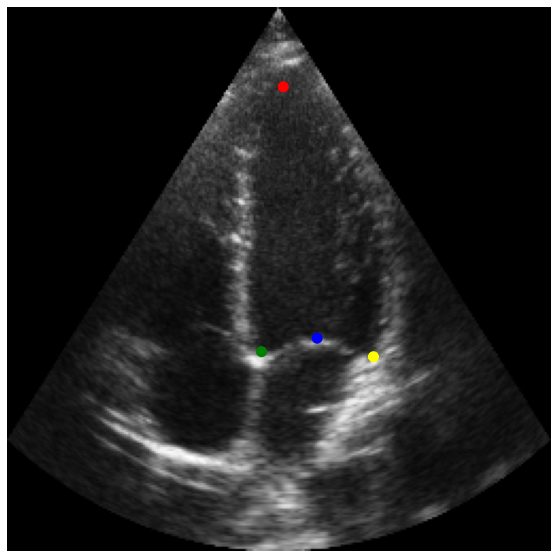

In [ ]:
plt.figure(figsize=(15,10))

plt.imshow(val_elem['data'][0,0,...].numpy(), cmap='gray')
plt.scatter(x[0][:,0], x[0][:,1], c=['red', 'blue', 'green', 'yellow'], s=100)
plt.axis('off')

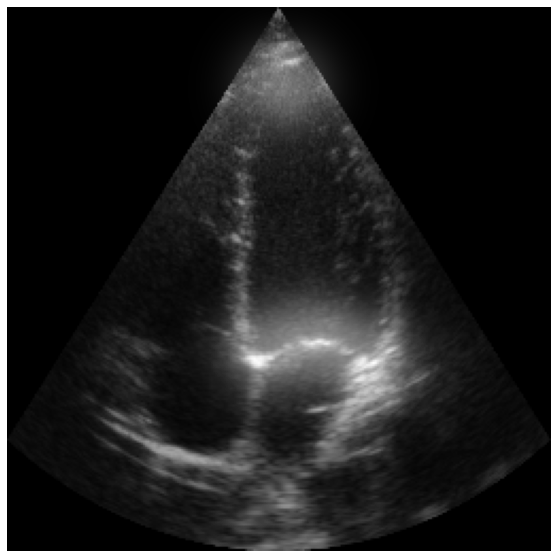

In [ ]:
import cv2
i = cv2.addWeighted(val_elem['data'][0,0,...].numpy(),1,heatmap.squeeze().sum(0).numpy(),.5,0)

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(i, cmap='gray')

In [ ]:
background = 1 - heatmap.sum(dim=1).unsqueeze(1).clip(0,1)
heatmap = torch.concat((heatmap,background), 1)

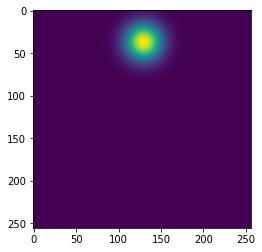

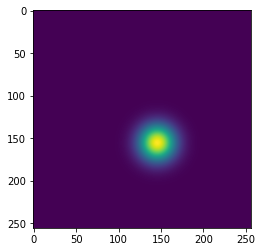

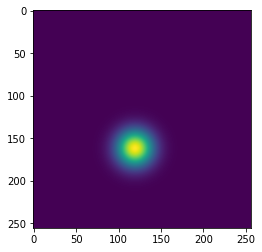

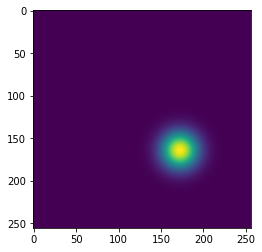

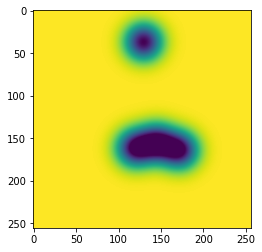

In [ ]:
for i in heatmap.squeeze():
    plt.imshow(i)
    plt.show()
    # print((i==i.max()).nonzero())

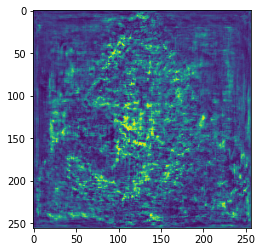

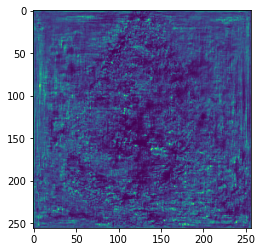

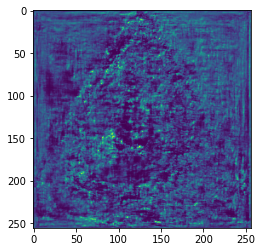

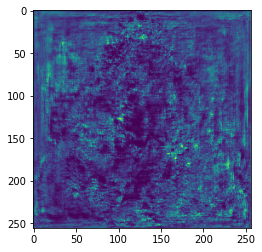

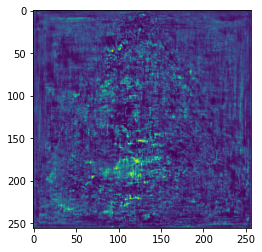

In [ ]:
predicted = []
for i in result[0].squeeze():
    a = i.detach().clone().numpy()
    # print(a)
    # a[a<=.3]=0
    
    plt.imshow(a)
    plt.show()
    predicted.append((a==a.max()).nonzero())
